In [ ]:
!pip install -U pip setuptools wheel
!pip install -U 'spacy[cuda-autodetect]'
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.1/805.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


  Preparing metadata (setup.py) ... done
  Obtaining dependency information for cupy-cuda11x==12.2.0 from https://files.pythonhosted.org/packages/27/50/dede8ba6e82b3c48d9d893d5ddfb148b87a8ea9dda582012cb102d3f2f4f/cupy_cuda11x-12.2.0-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 7.9 MB/s eta 0:00:00
  Created wheel for cupy-wheel: filename=cupy_wheel-12.2.0-py3-none-any.whl size=993 sha256=80699b3f0bf395cdf8a46cd5252b30ee3ba07c3308015474c97b01bea7487c0f
  Stored in directory: /root/.cache/pip/wheels/cb/49/ab/11325e9e6a58602b330dc974724e3e3d95934370b29e546056
Successfully built cupy-wheel
2023-09-01 21:10:35.824804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 21:10:37.549145: W tensorf

In [ ]:
import numpy as np
import tensorflow as tf
from keras.layers import *
from keras.models import Model
from keras.utils import plot_model
import keras.backend as K

In [ ]:
import sys
import spacy
from spacy.attrs import ORTH
from spacy.vocab import Vocab
from spacy.tokenizer import Tokenizer

nlp = spacy.load('ru_core_news_sm')
nlp.tokenizer.add_special_case('<sos>', [{ORTH: "<sos>"}])
nlp.tokenizer.add_special_case('<eos>', [{ORTH: "<eos>"}])

In [ ]:
import json
with open('/content/drive/MyDrive/Unивerchик/мага/1 курс/gazeta_train.jsonl', encoding='utf8') as f:
    data = [json.loads(line) for line in f]

for i in range(len(data)):
  # data[i]['text'] = "<sos> " + data[i]['text'] + " <eos>"
  data[i]['text'] = data[i]['text'].lower()
  data[i]['summary'] = "<sos> " + data[i]['summary'] + " <eos>"
  data[i]['summary'] = data[i]['summary'].lower()

In [ ]:
with open('/content/drive/MyDrive/Unивerchик/мага/1 курс/vocab_small_20000.txt', encoding='utf8') as f:
    vocab = f.read().splitlines()
vocab = list(set(vocab))
del vocab[vocab.index(' ')]
del vocab[vocab.index('')]

In [ ]:
DENSE_OUTPUT = len(vocab)

In [ ]:
len(vocab)

388729

In [ ]:
def spacy_split(input_data):
  doc = nlp(input_data.numpy().decode('utf8').lower())
  splitted_data = []
  for token in doc:
    splitted_data.append(token.text)
  return np.array(splitted_data)

In [ ]:
vectorization_layer = TextVectorization(standardize=None, split=spacy_split, vocabulary=vocab)
encoding_layer = CategoryEncoding(num_tokens=len(vocab)+2, output_mode="one_hot")

In [ ]:
encoding_layer(vectorization_layer(data[i]['summary'])).numpy()[:-1].shape

(52, 388731)

In [ ]:
encoder_inputs = Input(shape=(None, 96))
encoder = LSTM(128, return_state=True, return_sequences=True)
encoder_outputs_1, state_h, state_c = encoder(encoder_inputs)
encoder = LSTM(128, return_state=True, return_sequences=True)
encoder_outputs_2, state_h, state_c = encoder(encoder_outputs_1)
encoder = LSTM(128, return_state=True, return_sequences=True)
encoder_outputs_3, state_h, state_c = encoder(encoder_outputs_2)
encoder = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_outputs_3)
# We discard `encoder_outputs` and only keep the states.
encoder_states1 = [state_h, state_c]
encoder_states2 = [state_h, state_c]
encoder_states3 = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, 96))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
train_decoder_lstm1 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
train_decoder_outputs1, _, _ = train_decoder_lstm1(decoder_inputs, initial_state=encoder_states1)

train_decoder_lstm2 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
train_decoder_outputs2, _, _ = train_decoder_lstm2(train_decoder_outputs1, initial_state=encoder_states2)

train_decoder_lstm3 = LSTM(128, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
train_decoder_outputs3, _, _ = train_decoder_lstm3(train_decoder_outputs2, initial_state=encoder_states3)

train_attention = Attention()
train_attention_output = train_attention([train_decoder_outputs3, encoder_outputs])

train_decoder_dense = Dense(DENSE_OUTPUT, activation='softmax')
train_decoder_outputs = train_decoder_dense(train_attention_output)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], train_decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 96)]   0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, None, 128),  115200      ['input_5[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 lstm_15 (LSTM)                 [(None, None, 128),  131584      ['lstm_14[0][0]']                
                                 (None, 128),                                               

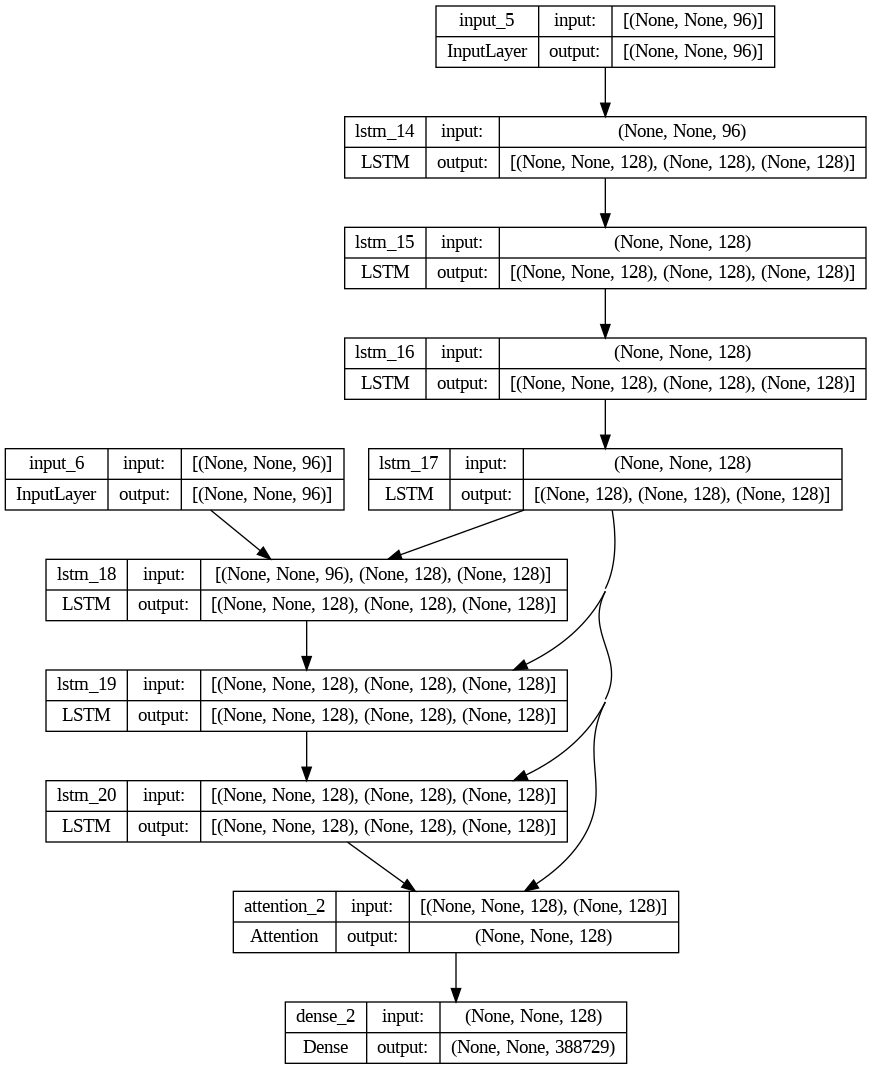

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states1)

inference_decoder_state_input_h1 = Input(shape=(128,))
inference_decoder_state_input_c1 = Input(shape=(128,))
inference_decoder_state_input_h2 = Input(shape=(128,))
inference_decoder_state_input_c2 = Input(shape=(128,))
inference_decoder_state_input_h3 = Input(shape=(128,))
inference_decoder_state_input_c3 = Input(shape=(128,))

inference_decoder_states_inputs = [inference_decoder_state_input_h1, inference_decoder_state_input_c1, inference_decoder_state_input_h2, inference_decoder_state_input_c2, inference_decoder_state_input_h3, inference_decoder_state_input_c3]
inference_decoder_outputs1, state_h1, state_c1 = train_decoder_lstm1(decoder_inputs, initial_state=[inference_decoder_state_input_h1, inference_decoder_state_input_c1])
inference_decoder_outputs2, state_h2, state_c2 = train_decoder_lstm2(inference_decoder_outputs1, initial_state=[inference_decoder_state_input_h2, inference_decoder_state_input_c2])
inference_decoder_outputs3, state_h3, state_c3 = train_decoder_lstm3(inference_decoder_outputs2, initial_state=[inference_decoder_state_input_h3, inference_decoder_state_input_c3])
inference_decoder_states = [state_h1, state_c1, state_h2, state_c2, state_h3, state_c3]
inference_decoder_outputs = train_decoder_dense(inference_decoder_outputs3)
decoder_model = Model(
    [decoder_inputs] + inference_decoder_states_inputs,
    [inference_decoder_outputs] + inference_decoder_states)

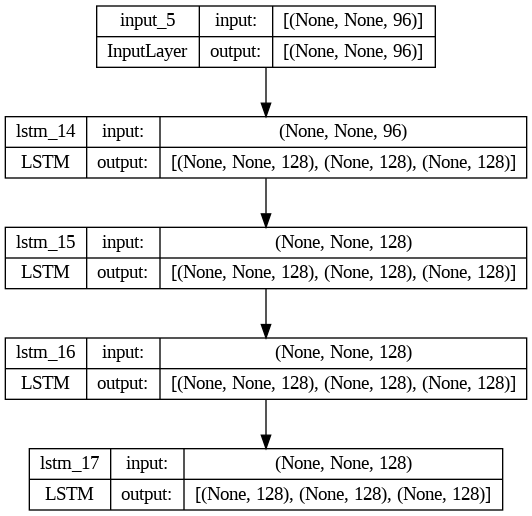

In [ ]:
plot_model(encoder_model, show_shapes=True)

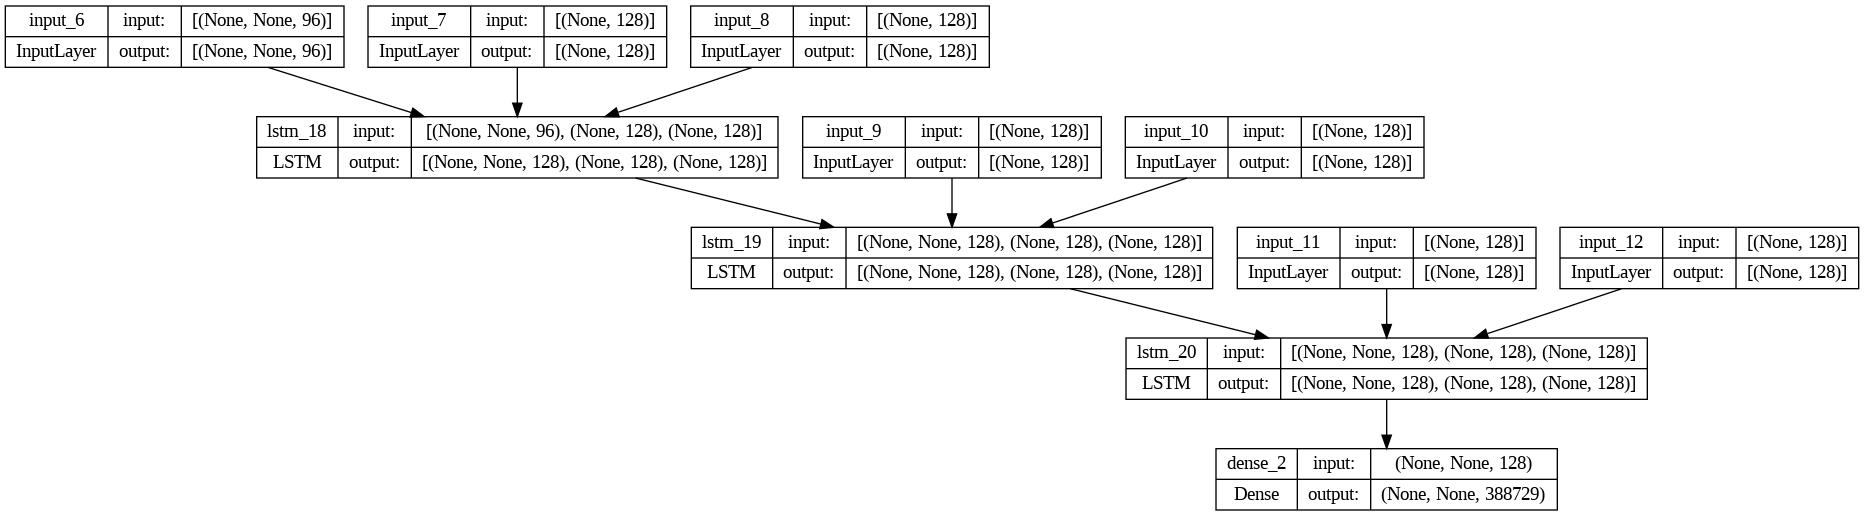

In [ ]:
plot_model(decoder_model, show_shapes=True)

In [ ]:
def prepaire_data(left_boundary, right_boundary):
  input_text = []
  input_summary = []
  test_summary = []
  for i in range(left_boundary, right_boundary):
    doc = nlp(data[i]['text'])
    temp_input_text = []
    for token in doc:
      temp_input_text.append(token.vector)
    doc = nlp(data[i]['summary'])
    temp_input_summary = []
    temp_test_summary = []
    for token in doc:
      temp_input_summary.append(token.vector)
    for token in doc:
      temp_test_summary.append(vocab.index(token.text))
    temp_input_text = np.array(temp_input_text)
    temp_input_summary = np.array(temp_input_summary[:-1])
    temp_test_summary = np.array(temp_test_summary[1:])
    input_text.append(temp_input_text.reshape(1,temp_input_text.shape[0],temp_input_text.shape[1]))
    input_summary.append(temp_input_summary.reshape(1,temp_input_summary.shape[0],temp_input_summary.shape[1]))
    test_summary.append(temp_test_summary.reshape(1,1,temp_test_summary.shape[0]))
  return input_text, input_summary, test_summary

In [ ]:
def train_model(step_size, end_step):
  left_boundary = 0
  right_boundary = step_size
  while left_boundary < end_step:
    input_text, input_summary, test_summary = prepaire_data(left_boundary, right_boundary)
    for i in range(step_size):
      model.fit([input_text[i], input_summary[i]], test_summary[i],
              batch_size=1,
              epochs=3000,
              verbose=2)

    del input_text[:]
    del input_summary[:]
    del test_summary[:]
    del input_text
    del input_summary
    del test_summary

    left_boundary = right_boundary
    right_boundary = right_boundary + step_size
    print("=========================" + str(left_boundary) + "=========================")

In [ ]:
train_model(1, 1)

Epoch 1/3000
1/1 - 21s - loss: 12.8707 - 21s/epoch - 21s/step
Epoch 2/3000
1/1 - 3s - loss: 12.8640 - 3s/epoch - 3s/step
Epoch 3/3000
1/1 - 3s - loss: 12.8444 - 3s/epoch - 3s/step
Epoch 4/3000
1/1 - 3s - loss: 12.8016 - 3s/epoch - 3s/step
Epoch 5/3000
1/1 - 3s - loss: 12.7280 - 3s/epoch - 3s/step
Epoch 6/3000
1/1 - 4s - loss: 12.6278 - 4s/epoch - 4s/step
Epoch 7/3000
1/1 - 4s - loss: 12.5110 - 4s/epoch - 4s/step
Epoch 8/3000
1/1 - 3s - loss: 12.3820 - 3s/epoch - 3s/step
Epoch 9/3000
1/1 - 2s - loss: 12.2389 - 2s/epoch - 2s/step
Epoch 10/3000
1/1 - 2s - loss: 12.0782 - 2s/epoch - 2s/step
Epoch 11/3000
1/1 - 3s - loss: 11.8981 - 3s/epoch - 3s/step
Epoch 12/3000
1/1 - 4s - loss: 11.6981 - 4s/epoch - 4s/step
Epoch 13/3000
1/1 - 3s - loss: 11.4787 - 3s/epoch - 3s/step
Epoch 14/3000
1/1 - 3s - loss: 11.2418 - 3s/epoch - 3s/step
Epoch 15/3000
1/1 - 3s - loss: 10.9907 - 3s/epoch - 3s/step
Epoch 16/3000
1/1 - 3s - loss: 10.7295 - 3s/epoch - 3s/step
Epoch 17/3000
1/1 - 5s - loss: 10.4625 - 5s/ep

KeyboardInterrupt: ignored

In [ ]:
data[0]['text']

'<sos> «по итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. при этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «интерфаксу» замминистра экономического развития андрей клепач. официальные прогнозы по выводу капитала из россии становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре минэкономразвития назвал цифру $50 млрд, в начале ноября центробанк пересмотрел оценку до $70 млрд. очередное изменение прогноза было ожидаемо: по расчетам центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «после октябрьских данных минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожидать серьезного замедления оттока капитала на непонятно каких причинах»,

In [ ]:
data[0]['summary']

'<sos> в 2011 году из россии уйдет $80 млрд, считают в минэкономразвития. менее месяца назад центробанк давал оценку $70 млрд, повысив первоначальный прогноз вдвое. отток капитала из страны усиливается из-за кризиса в европе, а в декабре российским компаниям выплачивать внешние долги. на движение капитала повлияли и выборы: несмотря на их предсказуемость, бизнес хочет ясности с перестановками в правительстве. <eos>'

In [ ]:
def decode_sequence(input_seq):
  max_decoder_seq_length = 200
  # Encode the input as state vectors.
  states_value1 = states_value2 = states_value3 = encoder_model.predict(input_seq)
  states_value = states_value1 + states_value2 + states_value3
  # Generate empty target sequence of length 1.
  doc = nlp("<sos>")
  target_seq = doc[0].vector.reshape(1,1,96) # (batch,time_steps,embeddings)

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = "<sos>"
  while not stop_condition:
    output_tokens, h1, c1, h2, c2, h3, c3 = decoder_model.predict([target_seq] + states_value)
    # Sample a token
    # sampled_token_index = np.argsort(output_tokens[0,-1,:])[-5:]
    # print(sampled_token_index)
    # sampled_token_index = np.random.choice(sampled_token_index, 1)[0]
    # print(sampled_token_index)
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = str(vocab[sampled_token_index])
    decoded_sentence += " " + sampled_char

    # Exit condition: either hit max length
    # or find stop character.
    if (len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True

    # Update the target sequence (of length 1).
    doc = nlp(sampled_char)
    target_seq = doc[0].vector.reshape(1,1,96)

    # Update states
    states_value = [h1, c1, h2, c2, h3, c3]
    print(decoded_sentence)

  return decoded_sentence

In [ ]:
_, _, temp_data = prepaire_data(0,1)

In [ ]:
temp_data[0][0][0]

array([258618,  56544, 116752, 195097,  59784, 269735, 185526,  47160,
       385455, 139640, 337856, 258618, 386081, 145517, 169708,  25741,
       377253, 192735, 206580,  51894, 185526, 365681, 385455, 139640,
        82163, 167026,  33668, 328169, 145517,  23898,  39844, 195097,
       141748, 179775, 195097,  17398, 363877,  52670, 258618, 334449,
       139640, 350561, 258618, 375429,  37937, 320776,  28593, 147792,
        30256, 145517, 372368, 279844,  39844, 177385,  75504, 144732,
       111203,  78264, 372368, 383653, 372458, 139640, 286600, 372551,
       385965, 111260,  53066, 258618, 184297, 145517,  42032])

In [ ]:
sentence = ""
for word in temp_data[0][0][0]:
  sentence += vocab[word] + " "

TypeError: ignored

In [ ]:
sentence

'в 2011 году из россии уйдет $ 80 млрд , считают в минэкономразвития . менее месяца назад центробанк давал оценку $ 70 млрд , повысив первоначальный прогноз вдвое . отток капитала из страны усиливается из - за кризиса в европе , а в декабре российским компаниям выплачивать внешние долги . на движение капитала повлияли и выборы : несмотря на их предсказуемость , бизнес хочет ясности с перестановками в правительстве . <eos> '

In [ ]:
temp_data, _, _ = prepaire_data(0,1)
print(decode_sequence(temp_data[0]))

1/1 [==============================] - 1s 645ms/step
<sos> в
1/1 [==============================] - 0s 27ms/step
<sos> в 2011
1/1 [==============================] - 0s 23ms/step
<sos> в 2011 2011
1/1 [==============================] - 0s 29ms/step
<sos> в 2011 2011 году
1/1 [==============================] - 0s 26ms/step
<sos> в 2011 2011 году россии
1/1 [==============================] - 0s 25ms/step
<sos> в 2011 2011 году россии в
1/1 [==============================] - 0s 25ms/step
<sos> в 2011 2011 году россии в $
1/1 [==============================] - 0s 23ms/step
<sos> в 2011 2011 году россии в $ $
1/1 [==============================] - 0s 25ms/step
<sos> в 2011 2011 году россии в $ $ $
1/1 [==============================] - 0s 24ms/step
<sos> в 2011 2011 году россии в $ $ $ млрд
1/1 [==============================] - 0s 23ms/step
<sos> в 2011 2011 году россии в $ $ $ млрд млрд
1/1 [==============================] - 0s 24ms/step
<sos> в 2011 2011 году россии в $ $ $ млрд млрд ,
1/

In [ ]:
# tokens = []
# for i in range(20000):
#   doc = nlp(data[i]['text'])
#   for token in doc:
#     tokens.append(token.text)
#   doc = nlp(data[i]['summary'])
#   for token in doc:
#     tokens.append(token.text)

In [ ]:
# len(set(tokens))

In [ ]:
# set_tokens = set(tokens)

In [ ]:
# file = open('vocab_small_20000.txt','w', encoding='utf8')
# for set_token in set_tokens:
# 	file.write(set_token + "\n")
# file.close()

In [ ]:
# from google.colab import files
# files.download('/content/vocab_small_20000.txt')